# Analisis Sentimen Notebook

Melakukan analisis sentimen pada data hasil crawling

## 1. Import Libraries

Import library yang akan digunakan

In [1]:
import re, json, string, pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

## 2. Load Dataset

Load data ke memmory menggunakan library pandas.

In [2]:
data1 = pd.read_csv('../data/Crawling Twitter Jakarta 26 - 27.csv')
data2 = pd.read_csv('../data/Crawling Twitter Jakarta 25 - 23.csv')
data3 = pd.read_csv('../data/Crawling Twitter Jakarta 22 - 19 setengah.csv')

**Menggabungkan data**

Menggabungkan 3 dataset tersebut menjadi satu

In [3]:
# Concate data
data = pd.concat([data1,data2,data3])
data.head()

,Tanggal,Tweets,ID,Screen Name,Banyak Retweet,Source,Retweet Status,Hashtags
0,2020-04-27 23:59:57,b'RT @ayanggwiwid: Bayangin kalo pabrik skinca...,1254923268621955072,vinnmuth,336,Twitter for Android,1,[]
1,2020-04-27 23:59:57,b'RT @okezonenews: Wali Kota Palangkaraya Posi...,1254923270333231105,Nila_Widuri,4,Twitter for Android,1,"['TauCepatTanpaBatas', 'BeritaTerkini', 'Berit..."
2,2020-04-27 23:59:56,b'RT @detikcom: Pemerintah negara bagian New S...,1254923263584514048,nafisines,12,Twitter for iPhone,1,[]
3,2020-04-27 23:59:52,b'RT @hilmi_fpi: Proses pngmasan pkt sahur ole...,1254923248657035265,Tengsyut07,285,Twitter for Android,1,[]
4,2020-04-27 23:59:49,b'RT @ulil: Kepada para anggota DPR: Jangan ke...,1254923236346720257,ChumaerohLaeli,665,Twitter Web App,1,[]


In [4]:
# Cleanner 
def cleaning(text):
    text= text[2:]
    text = text.replace('\\n',' ')
    return text

In [5]:
tweets =  data['Tweets'].apply(cleaning).values
tweets

array(["RT @ayanggwiwid: Bayangin kalo pabrik skincare ditutup gara gara corona, burik burik dah lu pada.'",
       "RT @okezonenews: Wali Kota Palangkaraya Positif Terjangkit Virus Corona   #TauCepatTanpaBatas #BeritaTerkini #BeritaDaerah . https://t.co/z\\xe2\\x80\\xa6'",
       "RT @detikcom: Pemerintah negara bagian New South Wales, Australia memindahkan ribuan warga tunawisma di negara bagiannya untuk tinggal di h\\xe2\\x80\\xa6'",
       ...,
       "RT @hsuf: Jika Indonesia ternyata berhasil melalui masa wabah ini dengan sukses, minim korban - #seperti dengan berbagai panduan dari @Kawa\\xe2\\x80\\xa6'",
       "RT @Aryprasetyo85: Semoga pemda nya gk tutup mata dan membantu keluarga ini  Memprihatinkan!! Satu Keluarga Kelaparan Tak Makan 2 Hari Kare\\xe2\\x80\\xa6'",
       "RT @Fahrihamzah: Politic &amp; Decision Making Penanganan COVID-19 https://t.co/UrFWlFXWHz'"],
      dtype=object)

## 2. Data Preprocessing

Preprocess data text sebelum diolah

## 2.1. Stemmer

> Stemming merupakan suatu proses untuk menemukan kata dasar dari sebuah kata. Dengan menghilangkan semua imbuhan (affixes) baik yang terdiri dari awalan (prefixes), sisipan (infixes), akhiran (suffixes) dan confixes (kombinasi dari awalan dan akhiran) pada kata turunan. Stemming digunakan untuk mengganti bentuk dari suatu kata menjadi kata dasar dari kata tersebut yang sesuai dengan struktur morfologi Bahasa Indonesia yang baik dan benar.

Membuat Stemmer menggunakan sastrawi.

In [6]:
# Create Sastrawi stemmer
stemmer = StemmerFactory().create_stemmer()

## 2.2. Stopwords

> Stop words adalah kata umum (common words) yang biasanya muncul dalam jumlah besar dan dianggap tidak memiliki makna.

Akan dibuat list yang berisi stopword yang ada pada bahasa indonesia.

In [7]:
# Create Stopword
with open("../kamus/Stopword.txt", "r") as f:
    stop_words = f.readline()
    stop_words = stop_words.split()

## 2.3. Preprocessing function

Akan dilakukan beberapa tahap untuk preprocess data text agar siap digunakan, yaitu:

1. Normalisasi karakter string menjadi huruf kecil
2. Menghapus emoji
3. Menghapus setiap url
4. Menghapus tagging
5. Menghapus whitespace
6. Menghapus simbol '#' pada hashtag
7. Menghapus angka
8. Mengganti tanda baca menjadi '<spasi>'

In [8]:
# Preprocessor
def preprocessor(text):
    # Convert to lower case
    text = text.lower()
    # Remove additional code
    text = text.replace('\\xe2\\x80\\xa6', '')
    # Convert www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    # Convert @username to AT_USER
    text = re.sub('@[^\s]+','',text)
    # Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    # Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1',text)
    # Menghapus angka dari teks
    text = re.sub(r"\d+", "", text)
    # Menganti tanda baca dengan spasi
    text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    return text

## 2.4. Tokenizer

Membuat custom tokenizer menggunakan `word_tokenize` dari library `nltk` lalu memfilter token tersebut.

In [9]:
# Tokenizer
def tokenizer(text):
    words = word_tokenize(text)
    tokens=[]
    for w in words:
        # add tokens
        if len(w) > 3:
            w = stemmer.stem(w)
            tokens.append(w.lower())
    return tokens

## 2.5. Text Vectorization

Text vectorization adalah cara melakukan encode data text menjadi numerik. Berikut akan dilakukan vectorization menggunakan `TfidfVectorizer` dari library `scikit-learn`. Untuk mempelajari text vectorization lebih lanjut dapat membaca artikel [berikut](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

In [13]:
# Defining Vectorizer object
#vectorizer_tfidf = TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, stop_words=stop_words, min_df=0.01, max_df=0.6)

# Load saved
vectorizer_tfidf = pickle.load(open('../model/vectorizer/vectorizer_tfidf.pickle', 'rb'))

**fit & transform**

Ubah data text menjadi encoded matrix

In [14]:
# fit and transform text data
#word_tfidf = vectorizer_tfidf.fit_transform(tweets)

# Load saved 
word_tfidf = pickle.load(open('../model/vectorizer/word_tfidf.pickle', 'rb'))

In [15]:
# Saving Model
#pickle.dump(vectorizer_tfidf, open("../model/vectorizer/vectorizer_tfidf.pickle", "wb"))
#pickle.dump(word_tfidf, open("../model/vectorizer/word_tfidf.pickle", "wb"))

Mengambil nama fitur / kata - kata yang terdapat dalam data dan melihat dimensi data setelah dilakukan vectorization menggunakan `TfidfVectorizer`

In [15]:
# Nama fitur
nama_fitur = vectorizer_tfidf.get_feature_names()

# Dimensi data
dimensions = word_tfidf.get_shape()
print(f"Jumlah artikel = {dimensions[0]}")
print(f"Jumlah fitur   = {dimensions[1]}")

Jumlah artikel = 250279
Jumlah fitur   = 142


## 2.6. Kata dengan bobot TF-IDF tertinggi

Melihat kata - kata dengan bobot TF-IDF tertinggi

In [16]:
content1, content2 = [], []

for n in range(dimensions[0]):
    # Convert sparse matrix row by row 
    row = word_tfidf.getrow(n).toarray()[0].ravel()
    # Get top values and its indexes 
    top_ten_indices = row.argsort()[-1]
    top_ten_values = row[row.argsort()[-1]]
    # Identify the highest TFIDF value and word #
    highestTFIDFword = nama_fitur[top_ten_indices]
    highestTFIDFvalue = top_ten_values
    top1word = {'nomor artikel': n+1, 'nilai TFIDF': highestTFIDFvalue,
                'top word': highestTFIDFword}
    content1.append(top1word)
    content2.append(highestTFIDFword)

# Hitung Frekuiensi kata dengan bobot terbesar
content2 = np.asarray(content2)
words, n = np.unique(content2, return_counts=True)

# Convert to DataFrame lalu urutkan secara descending
# lalu pilih 20 kata dengan frekuensi terbesar 
words_data = pd.DataFrame({
    'Kata': words,
    'Banyak': n
}).sort_values(by='Banyak', ascending=False).head(20)
words_data 

,Kata,Banyak
133,ustadz,20670
17,corona,7951
139,your,7655
90,plasma,5593
35,gadis,5540
84,pandemi,5360
19,covid,5040
30,dude,4619
66,lupa,4610
27,dirumahaja,3792


**Visualisasi hasil**

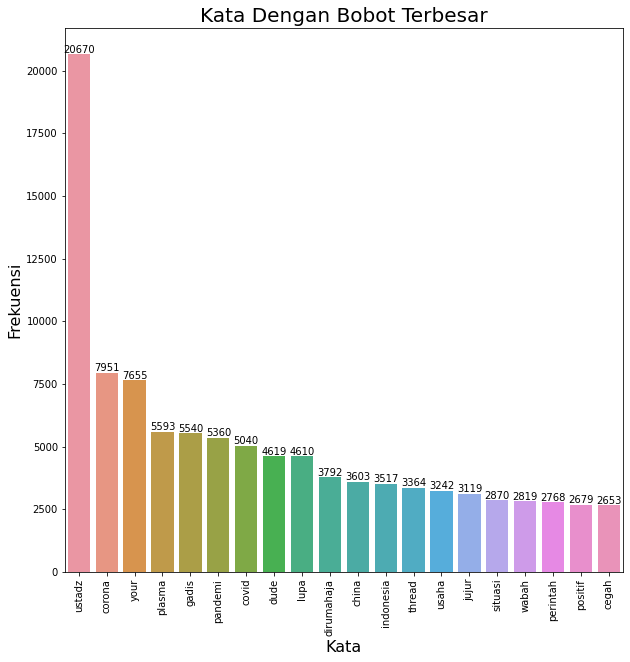

In [17]:
# Plotting Barplot
plt.figure(figsize = (10,10))
sns.barplot(x = words_data['Kata'],y = words_data['Banyak'])
for i, v in enumerate(words_data['Banyak'].tolist()):
    plt.text(i-len(str(v))/10-.05, v + 50, str(v),fontsize=10)
plt.title('Kata Dengan Bobot Terbesar',fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Kata',fontsize=16)
plt.ylabel('Frekuensi',fontsize=16)
plt.show()

In [18]:
# Loading Sample tweet sentiment
sample = pd.read_csv('../data/Sample Tweet.csv')
sample.head()

,Index,Tweets,Sentiment
0,51365,b'Salut! Polri mendapat apresiasi dari DPR RI ...,1
1,94963,b'Sebelum booming corona biasanya ke pasar non...,-1
2,16832,b'Covid 19 plus 30 ribu narapidana https://t.c...,-1
3,29905,"b'@faruqhmd Lu corona ora, muntaber iya.'",-1
4,25279,b'3. Jenazah belum dapat dipastikan apakah pos...,0


In [19]:
x = vectorizer_tfidf.transform(sample['Tweets'].values)
y = sample['Sentiment'].values

KeyboardInterrupt: 

In [ ]:
# Split training and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2020)

In [ ]:
# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn import metrics

classifiers = {
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(),
    "SVM": SVC()
}

for name in classifiers.keys():
    classifiers[name].fit(x_train,y_train)
    y_pred = classifiers[name].predict(x_test)
    print(f"Akurasi dari {name} : ",metrics.accuracy_score(y_test, y_pred))

In [ ]:
data['prediction'] = classifiers['SVM'].predict(word_tfidf)
data.head()

In [32]:
# Export data baru
Data.to_csv('Dataset/Data Sentiment Twitter 19 - 27 April.csv',index=False)

In [33]:
# EDA Sentiment
# Perbandingan
sentimen = Data['Tweets'].groupby(Data['Sentiment']).count()
temp = sentimen.values

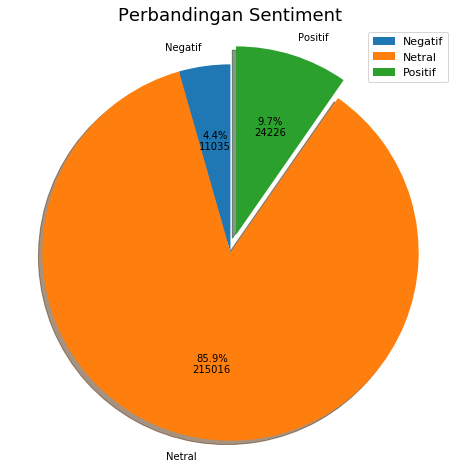

In [34]:
# Plotting Pie
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d}".format(pct, absolute)

plt.figure(figsize = (8,8))
plt.pie(temp,explode=(0,0,0.1),labels=['Negatif','Netral','Positif'],shadow=True,
        autopct=lambda pct: func(pct, temp),startangle=90)
plt.title('Perbandingan Sentiment',fontsize=18)
plt.axis('equal')
plt.legend(fontsize=11)
plt.show()

In [35]:
# Melihat banyak Tweet perhari berdasarkan sentiment
Data['Tanggal'] = pd.to_datetime(Data['Tanggal'])
tph = Data['Tweets'].groupby([Data['Tanggal'].dt.date,Data['Sentiment']]).count()
frek = tph.values

In [36]:
# To Data Frame
tanggal = [ i for i, j in tph.index.tolist() ]
senti = [ j for i, j in tph.index.tolist() ]
sent = pd.DataFrame({'Tanggal':tanggal,'Sentiment':senti,'Frekuensi':frek})

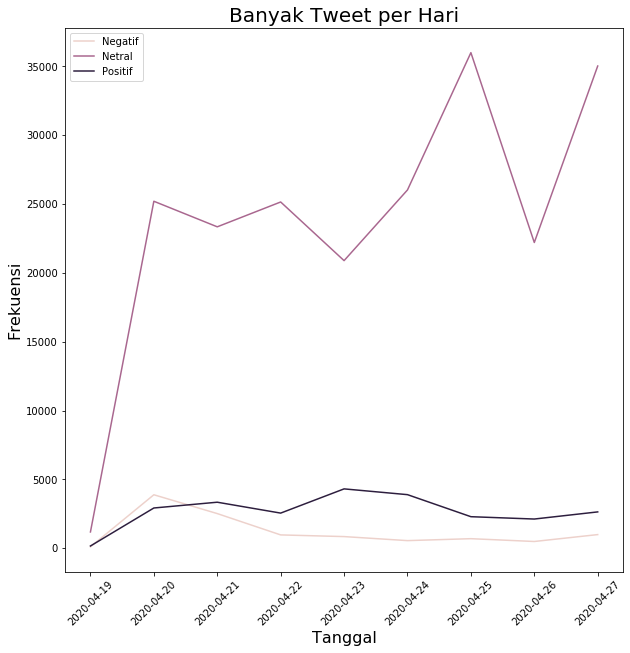

In [37]:
# Plotting line
plt.figure(figsize = (10,10))
sns.lineplot(x='Tanggal',y='Frekuensi',hue='Sentiment',data=sent)
plt.title('Banyak Tweet per Hari',fontsize=20)
plt.xticks(rotation=45)
plt.xlabel('Tanggal',fontsize=16)
plt.ylabel('Frekuensi',fontsize=16)
plt.legend(['Negatif','Netral','Positif'])
plt.show()

In [ ]:
#Selesai
#Terima Kasih